# Matching Synthetic Point Clouds

This notebook reproduces the synthetic point cloud matching experiment from our paper.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import warnings
import itertools
import plotly.graph_objects as go

from gtda.plotting import plot_point_cloud
from ripser import ripser
from persim import PersistenceImager, plot_diagrams
import gudhi as gd
from ot import fused_gromov_wasserstein2
import ot

import trimesh

from DecoratedReebGraphs import *

from gtda.plotting import plot_point_cloud

### Synthetic Data Generating Functions

Some functions for generating synthetic point cloud shapes.

In [2]:
def sample_points_from_solid_torus(num_points,major_radius,minor_radius):
    
    points = []
    
    while len(points) < num_points:
        
        theta = 2*np.pi*np.random.uniform(0,1)
        psi = 2*np.pi*np.random.uniform(0,1)
        r = minor_radius * np.sqrt(np.random.uniform(0, 1))
        
        x = r*np.sin(psi)
        y = major_radius*np.cos(theta) + r*np.cos(psi)*np.cos(theta)
        z = major_radius*np.sin(theta) + r*np.cos(psi)*np.sin(theta)
        
        points.append([x,y,z])
        
    return np.array(points)

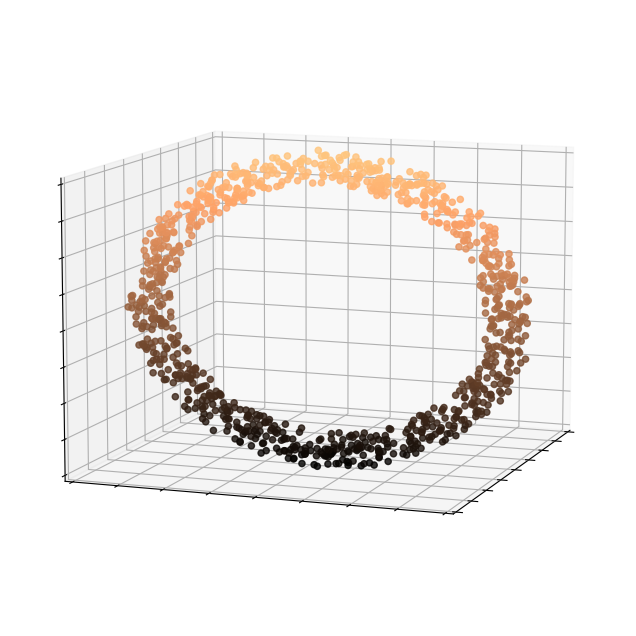

In [3]:
points = sample_points_from_solid_torus(1000,8,1)
plot_3d_point_cloud(points, box = (-8,8))

In [4]:
def sample_points_from_torus(num_points, major_radius, minor_radius):
    
    points = []
    
    while len(points) < num_points:
        
        theta = 2*np.pi*np.random.uniform(0,1)
        psi = 2*np.pi*np.random.uniform(0,1)
        r = minor_radius
        
        x = r*np.sin(psi)
        y = major_radius*np.cos(theta) + r*np.cos(psi)*np.cos(theta)
        z = major_radius*np.sin(theta) + r*np.cos(psi)*np.sin(theta)
        
        points.append([x,y,z])
        
    return np.array(points)

    return np.array(points)

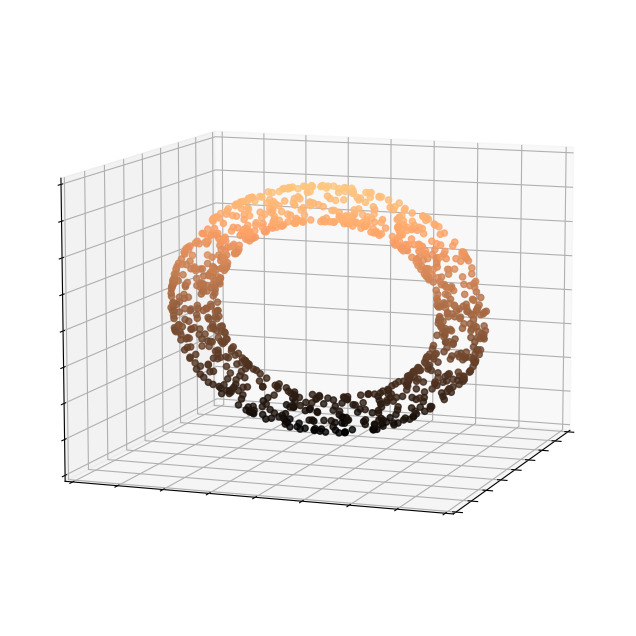

In [5]:
points = sample_points_from_torus(1000,6,1)
plot_3d_point_cloud(points, box = (-8,8))

In [6]:
def sample_points_from_solid_cylinder(num_points,radius,length):
    
    points = []
    
    while len(points) < num_points:
        
        theta = 2*np.pi*np.random.uniform(0,1)
        r = radius * np.sqrt(np.random.uniform(0, 1))
        
        x = r*np.cos(theta)
        y = r*np.sin(theta)
        z = length * np.random.uniform(0, 1)
        
        points.append([x,y,z])
        
    return np.array(points)

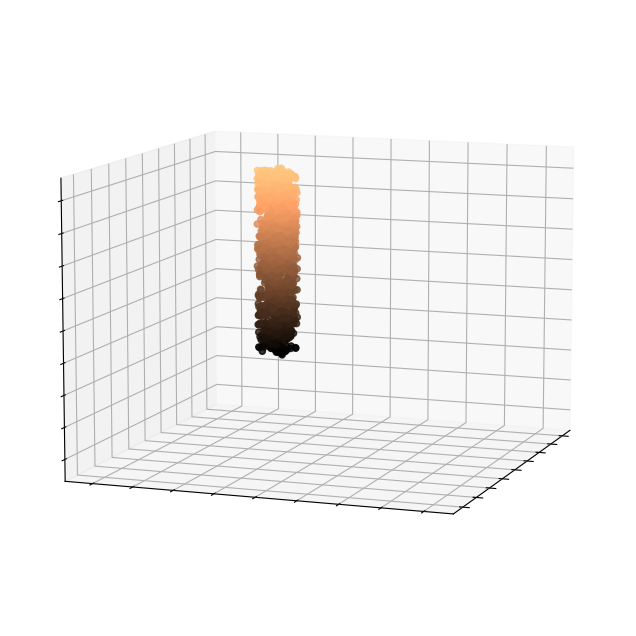

In [7]:
points = sample_points_from_solid_cylinder(1000,1,12)
plot_3d_point_cloud(points, box = (-5,13))

In [8]:
def sample_points_from_cylinder(num_points,radius,length):
    
    points = []
    
    while len(points) < num_points:
        
        theta = 2*np.pi*np.random.uniform(0,1)
        r = radius
        
        x = r*np.cos(theta)
        y = r*np.sin(theta)
        z = length * np.random.uniform(0, 1)
        
        points.append([x,y,z])
        
    return np.array(points)

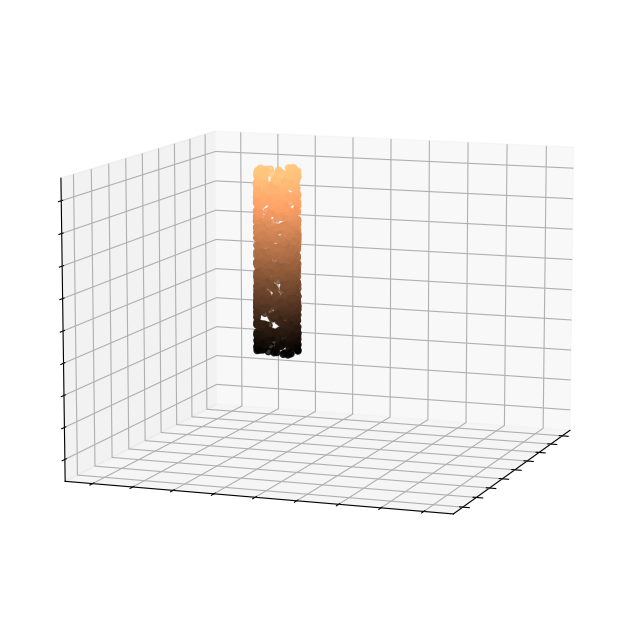

In [9]:
points = sample_points_from_cylinder(1000,1,12)
plot_3d_point_cloud(points, box = (-5,13))

### Change to Distance Function

We add a tweak to the distance function which includes an extra parameter for rescaling attribution distances.

In [27]:
def DRG_distance(G1,G2,attribute,matrix_style = 'distance',alpha = 0.5, attribution_rescale = 1.0):

    C1,p1 = DRG_to_measure_network(G1, matrix_style = matrix_style)
    C2,p2 = DRG_to_measure_network(G2, matrix_style = matrix_style)

    if attribute == 'none':
        M = np.zeros([len(C1),len(C2)])
        dist = fused_gromov_wasserstein2(M,C1,C2,p1,p2,alpha = 1)

    else:
        M = attribution_rescale*get_attribution_distances(G1,G2,attribute)**2
        dist = fused_gromov_wasserstein2(M,C1,C2,p1,p2,alpha = alpha)

    return dist

### Creating a Dataset

In [11]:
from scipy.linalg import orth

Creating Shapes

In [21]:
num_shapes_per_class = 5 # We used 20 shapes per class in the paper
major_radius = 6
minor_radius = 1
radius_noise_level = 0.05
data_noise_level = 0.2
num_points = 400

tori = []
solid_tori = []
cylinders = []
solid_cylinders = []

for j in range(num_shapes_per_class):
    
    torus = sample_points_from_torus(num_points, 
                                     major_radius + radius_noise_level*np.random.uniform(0,1),
                                    minor_radius + radius_noise_level*np.random.uniform(0,1))
    
    torus += data_noise_level*np.random.normal(0,1,torus.shape)
    A = orth(np.random.normal(0,1,(3,3)))
    torusNew = (torus - np.mean(torus,axis = 0))@A
    
    tori.append(torusNew)
    
    solid_torus = sample_points_from_solid_torus(int(4*num_points), 
                                     major_radius + radius_noise_level*np.random.uniform(0,1),
                                    minor_radius + radius_noise_level*np.random.uniform(0,1))
    
    solid_torus += data_noise_level*np.random.normal(0,1,solid_torus.shape)
    
    A = orth(np.random.normal(0,1,(3,3)))
    solid_torusNew = (solid_torus - np.mean(solid_torus,axis = 0))@A
    
    solid_tori.append(solid_torusNew)
    
    cylinder = sample_points_from_cylinder(num_points,
                                minor_radius + radius_noise_level*np.random.uniform(0,1),
                                      2*np.pi*(minor_radius+major_radius) + radius_noise_level*np.random.uniform(0,1))

    cylinder += data_noise_level*np.random.normal(0,1,cylinder.shape)
    A = orth(np.random.normal(0,1,(3,3)))
    cylinderNew = (cylinder - np.mean(cylinder,axis = 0))@A
    cylinders.append(cylinderNew)
    
    solid_cylinder = sample_points_from_solid_cylinder(int(4*num_points),
                                    minor_radius + radius_noise_level*np.random.uniform(0,1),
                                          2*np.pi*(minor_radius+major_radius) + radius_noise_level*np.random.uniform(0,1))
    
    solid_cylinder += data_noise_level*np.random.normal(0,1,solid_cylinder.shape)
    
    A = orth(np.random.normal(0,1,(3,3)))
    solid_cylinderNew = (solid_cylinder - np.mean(solid_cylinder,axis = 0))@A
    
    solid_cylinders.append(solid_cylinderNew)

all_shapes = tori + solid_tori + cylinders + solid_cylinders

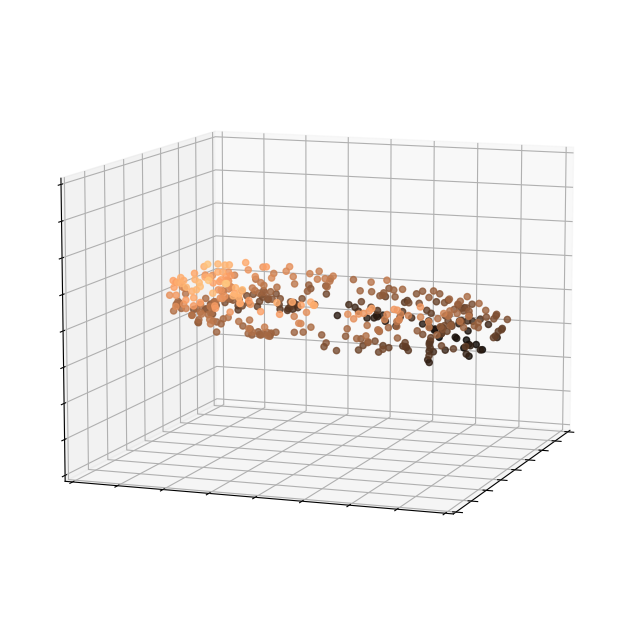

In [22]:
plot_3d_point_cloud(all_shapes[0], box = (-8,8))

The following is used to ignore warnings about point cloud dimensions in the persistent homology calculations. This can be skipped, if that sort of thing makes you nervous.

In [23]:
import warnings
warnings.filterwarnings("ignore")

Create DRGs from the shapes.

In [24]:
%%time

from sklearn.decomposition import PCA
pca = PCA(n_components=1)

# Parameters for local method
n_bins_factor = 1/2
birth_range = (0,2)
simplify = False
kernel_params = {'sigma': [[0.001, 0.0], [0.0, 0.001]]}

# Parameters for global method
truncation_factor = 5
birth_range_global = (0,100)
pixel_size_global = 10
kernel_params_global = {'sigma': [[0.1, 0.0], [0.0, 0.1]]}


DRGs = []

for i,shape in enumerate(all_shapes):
    
    data = shape
    function = pca.fit_transform(data).T[0]
    
    width = max(function) - min(function)
    n_bins = int(n_bins_factor*width)
    
    DRG = DecoratedReebGraph(data = data, function = function)
    DRG.fit_Vietoris_Rips()
    DRG.fit_Reeb(n_bins = n_bins)
    DRG.fit_diagrams(persistence_images=True, birth_range = birth_range, kernel_params = kernel_params)
    
    DRG.fit_diagrams_global(persistence_images=True, birth_range = birth_range_global,
                            kernel_params = kernel_params_global, pixel_size = pixel_size_global,
                            truncate_inf = True, truncation_factor = truncation_factor)    
    
    DRGs.append(DRG.ReebGraph)
    
    print(f'Shape {i} done')

Shape 0 done
Shape 1 done
Shape 2 done
Shape 3 done
Shape 4 done
Shape 5 done
Shape 6 done
Shape 7 done
Shape 8 done
Shape 9 done
Shape 10 done
Shape 11 done
Shape 12 done
Shape 13 done
Shape 14 done
Shape 15 done
Shape 16 done
Shape 17 done
Shape 18 done
Shape 19 done
CPU times: user 1min 5s, sys: 32.2 s, total: 1min 37s
Wall time: 59.6 s


## Computing Pairwise Distances

For various choices of $\alpha$ in the FGW distance, we compute pairwise distance matrix from our dataset.

MDS plots of the resulting distance matrices are shown below.

Pairwise distances using the local approach.

In [25]:
alphas = [0,.25,0.5,1.0]
PI_distance_matrices = []
verbose = False

attribute = 'persistence_image'

for alpha in alphas:
    
    distances = np.zeros([len(DRGs),len(DRGs)])
    
    for i in range(len(DRGs)):
        if verbose:
            print('row=',i)
        G1 = DRGs[i]
        for j in range(i+1,len(DRGs)):
            G2 = DRGs[j]
            distances[i,j] = DRG_distance(G1,G2,attribute,
                                          matrix_style = 'distance',alpha = alpha,
                                         attribution_rescale=10)

    distances = distances + distances.T
    
    PI_distance_matrices.append(distances)
    
    print(f'{alpha} Done')

0 Done
0.25 Done
0.5 Done
1.0 Done


Displaying MDS plots.

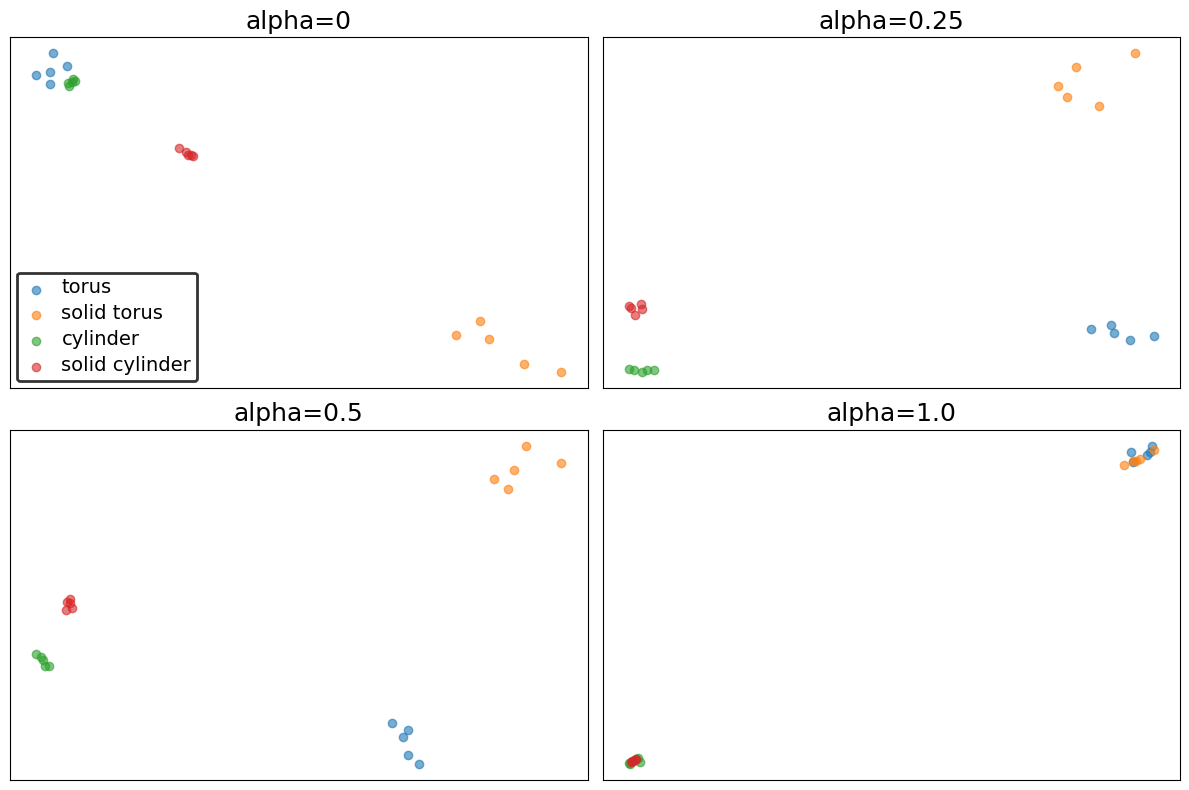

In [26]:
from sklearn.manifold import MDS

labels = ['torus','solid torus','cylinder','solid cylinder']

# Define the number of subplots and the number of columns
num_plots = len(PI_distance_matrices)
num_columns = 2  # Number of columns for each row

# Calculate the number of rows needed
num_rows = int(np.ceil(num_plots / num_columns))

# Create a figure and subplots
fig, axs = plt.subplots(num_rows, num_columns, figsize=(12, 4*num_rows))

# Iterate over each distance matrix and create the MDS plot
for i, distance_matrix in enumerate(PI_distance_matrices):
    # Calculate the subplot indices based on the current plot index
    row_idx = i // num_columns
    col_idx = i % num_columns
    
    # Perform MDS
    mds = MDS(n_components=2, dissimilarity='precomputed')
    embedding = mds.fit_transform(distance_matrix)
    
    # Plot the MDS plot in the corresponding subplot
    for j in range(4):

        scatter = axs[row_idx, col_idx].scatter(embedding[(j)*num_shapes_per_class:(j+1)*num_shapes_per_class, 0],
                                      embedding[(j)*num_shapes_per_class:(j+1)*num_shapes_per_class, 1],
                                     label = labels[j],
                                     alpha = 0.6)
    axs[row_idx, col_idx].set_title(f"alpha={alphas[i]}",fontsize=18)
    
    # Remove axis ticks
    axs[row_idx, col_idx].set_xticks([])
    axs[row_idx, col_idx].set_yticks([])
    
    if i == 0:
        legend = axs[row_idx, col_idx].legend(loc='lower left')
        
        legend.get_frame().set_linewidth(2)
        legend.get_frame().set_edgecolor('black')
        for text in legend.get_texts():
            text.set_fontsize(14)

# Adjust the layout
plt.tight_layout()

# Display the plot
plt.show()
